# Influenza cases

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

## Influenza cases

In [2]:
# Load prep data
with open('L:\Dor\Data\vaccination_model\prep_data.pickle', 'rb') as pickle_in:
    prep_data = pickle.load(pickle_in)
    
# Get population by clinic and age in Macabi data and in the network
population_by_clinic_age = prep_data['population_by_clinic_age'].copy()

In [3]:
diagnoses = pd.read_csv('L:\Dor\Data\influenza_model\data\sample_diagnoses.txt')
diagnoses.diagnosis_code = diagnoses.diagnosis_code.map(lambda x: x.strip())

# Get only influenza cases
relevant_diagnosis_codes = set(['478.9', '482.2', '482.2', '487.0', '487  ', '487  ', '487.1', 'Y22844', 'Y14678', 'Y14678',
                                'Y14696', 'Y23242', 'Y23637', 'Y14697'])
influenza_diagnoses = diagnoses[diagnoses.diagnosis_code.isin(relevant_diagnosis_codes)].copy()

# Convert the date to TimeStamp object
influenza_diagnoses.date_diagnosis = influenza_diagnoses.date_diagnosis.map(lambda x: pd.Timestamp(year=int(str(x)[:4]), month=int(str(x)[4:6]), day=int(str(x)[6:])))

# Sort by date
influenza_diagnoses.sort_values('date_diagnosis', inplace=True)

# Add season column
influenza_diagnoses['season'] = influenza_diagnoses.date_diagnosis.map(lambda date: date.year+1 if date.month >=6 else date.year)

# Get only cases in last 5 seasons
influenza_diagnoses = influenza_diagnoses[influenza_diagnoses.season.isin([2011,2012,2013,2014,2015,2016,2017])].copy()
# influenza_diagnoses = influenza_diagnoses[influenza_diagnoses.season.isin([2013,2014,2015,2016,2017])].copy()  ### 5 SEASONS!!!


# Add age
# Load demographic data
demographic_data = pd.read_csv('L:\Dor\Data\influenza_model\data\sample_dem_data.txt')

# Add birth year to the diagnoses data
influenza_diagnoses = influenza_diagnoses.merge(demographic_data[['random_ID', 'birth_year', 'stat_code']], left_on='random_ID',
                                                right_on='random_ID')

# Add age at diagnosis date column
influenza_diagnoses['age'] = influenza_diagnoses.apply(lambda row: ((row.date_diagnosis.year - row.birth_year) > 18), axis=1).astype(int)

# Get only relevant columns
influenza_diagnoses = influenza_diagnoses[['random_ID', 'season', 'age', 'stat_code', 'date_diagnosis']].copy()
influenza_diagnoses.columns = ['random_ID', 'season', 'age', 'clinic_code', 'date_diagnosis']

# Sort by date
influenza_diagnoses.sort_values('date_diagnosis', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create daily influenza data

In [ ]:
# Group by date
influenza_cases = influenza_diagnoses.copy()
influenza_cases = influenza_cases.groupby(['clinic_code', 'age', 'date_diagnosis']).count()[['random_ID']]

# Initialize a Data frame with all relevant dates
dates = [pd.Timestamp(2010,6,1) + pd.Timedelta(i, unit='d') for i in range(365*7+2)]
# dates = [pd.Timestamp(2012,6,1) + pd.Timedelta(i, unit='d') for i in range(365*5)]  #### 5 SEASONS!!!
influenza_cases_daily = pd.DataFrame(list(product(dates, influenza_diagnoses.clinic_code.unique(), [0,1])),
                                     columns=['date', 'clinic_code', 'age'])
influenza_cases_daily.set_index(['clinic_code', 'age', 'date'], inplace=True)

# Add the number of case for each date (0 if there are none)
influenza_cases_daily['cases'] = influenza_cases_daily.index.map(lambda x:
                                                                 influenza_cases.loc[x] if x in influenza_cases.index else 0)
influenza_cases_daily.cases = influenza_cases_daily.cases.astype(int)
influenza_cases_daily.reset_index(inplace=True)

# Aggregate weekly cases by clinic and age
# Initialize a dictionary
influenza_weekly_cases_by_clinic_age = {}

# Go over all combinations of clinic_code and age and aggregate weekly
# for clinic, age in product(influenza_diagnoses.clinic_code.unique(), [0,1]):
for clinic, age in population_by_clinic_age.index:
    # Get only relevant clinc and age
    cur_influenza_cases = influenza_cases_daily[(influenza_cases_daily.clinic_code == clinic)&(influenza_cases_daily.age == age)].copy()
    # Aggregate weekly
    cur_influenza_weekly_cases = cur_influenza_cases.set_index('date').resample('W').sum()[['cases']].copy()
    # Add season column
    cur_influenza_weekly_cases['season'] = cur_influenza_weekly_cases.index.map(lambda date: date.year+1 if date.month >=6
                                                                                else date.year)
    cur_influenza_weekly_cases.columns = ['cases', 'season']
    cur_influenza_weekly_cases = cur_influenza_weekly_cases[['season', 'cases']]
    # Add to the dictionary
    influenza_weekly_cases_by_clinic_age[(clinic, age)] = cur_influenza_weekly_cases[:-1].copy()
    
# Update the total by age group as a sum of all the relevnat clinic, age groups
# Initialize a dictionary
influenza_weekly_cases_by_age = {age: list(influenza_weekly_cases_by_clinic_age.values())[0].copy()
                                       for age in [0, 1]}
# Children
influenza_weekly_cases_by_age[0].cases = sum([influenza_weekly_cases_by_clinic_age[(clinic, age)].cases.values.copy() 
                                             for clinic, age in influenza_weekly_cases_by_clinic_age if age == 0])
# Adults
influenza_weekly_cases_by_age[1].cases = sum([influenza_weekly_cases_by_clinic_age[(clinic, age)].cases.values.copy()
                                             for clinic, age in influenza_weekly_cases_by_clinic_age if age == 1])


# Update the total as a sum of all the clinics and age groups
total_influenza_weekly_cases = influenza_weekly_cases_by_age[0].copy()
total_influenza_weekly_cases.cases = sum([influenza_weekly_cases_by_clinic_age[(clinic, age)].cases.values.copy()
                                          for clinic, age in influenza_weekly_cases_by_clinic_age])

In [ ]:
plt.figure(figsize=(15,7))
influenza_weekly_cases_by_age[0].cases.plot()
influenza_weekly_cases_by_age[1].cases.plot()
total_influenza_weekly_cases.cases.plot()
plt.show()

In [ ]:
total_influenza_weekly_cases.shape

In [78]:
total_influenza_weekly_cases[total_influenza_weekly_cases.season==2013].iloc[26:36].sum()

season    20130
cases      1616
dtype: int64

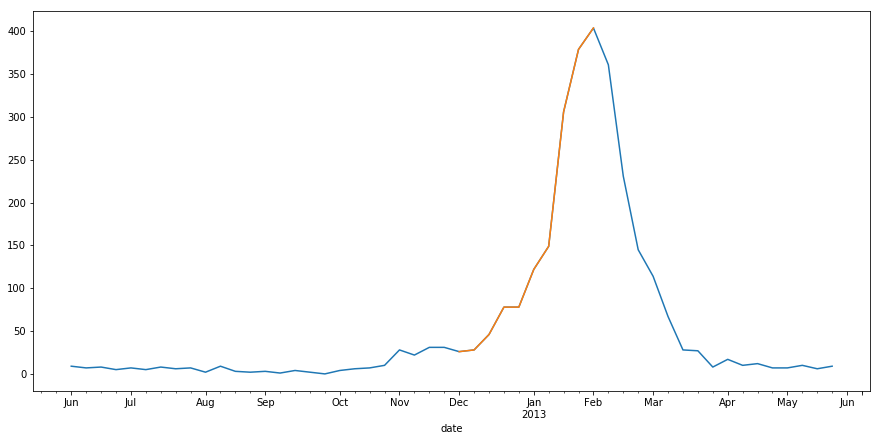

In [81]:
plt.figure(figsize=(15,7))
total_influenza_weekly_cases[total_influenza_weekly_cases.season==2013].cases.plot()
total_influenza_weekly_cases[total_influenza_weekly_cases.season==2013].iloc[26:36].cases.plot()

In [67]:
relevant_clinics = [c for c, a in prep_data['relevant_clinics_age']]
relevant_clinics = np.unique(relevant_clinics)
relevant_clinics

array([2207, 2209, 2210, 2211, 2212, 2213, 2215, 2216, 3303, 3304, 3305,
       3306, 3307, 3308, 3309, 3310, 3311, 3312, 3314, 3315, 3318, 3320,
       3321, 3322, 4403, 4404, 4405, 4407, 4408, 4409, 4410, 4411, 4412,
       4413, 4414, 5504, 5505, 5506, 5507, 5509, 5510, 5511, 5512, 5513,
       5514, 5516, 5517, 5521, 5522, 5523, 5525, 5526, 5527, 5528, 5529,
       5531, 5532, 5533, 5534, 5535, 6605, 6607, 6610, 6611, 6613, 6614,
       6615, 6616, 6617, 6618, 6619, 6624, 6626, 7704, 7713, 7714, 7720],
      dtype=int64)

In [121]:
cases_2013 = {}

for clinic in relevant_clinics:
    
    cur_clinic_data = influenza_weekly_cases_by_clinic_age[(clinic, 1)]
    
    if (clinic, 0) in prep_data['relevant_clinics_age']:
        cur_clinic_data.cases += influenza_weekly_cases_by_clinic_age[(clinic, 0)].cases 

    # Get only 2013 season
    cur_clinic_data = cur_clinic_data[cur_clinic_data.season==2013].iloc[26:36].copy()
    cur_clinic_data = cur_clinic_data/cur_clinic_data.sum()
    
    cases_2013[clinic] = cur_clinic_data

In [122]:
cases_2013[clinic].iloc[:]

,season,cases
date,,
2012-12-02,0.1,0.000000
2012-12-09,0.1,0.000000
2012-12-16,0.1,0.000000
2012-12-23,0.1,0.000000
2012-12-30,0.1,0.000000
2013-01-06,0.1,0.000000
2013-01-13,0.1,0.666667
2013-01-20,0.1,0.333333
2013-01-27,0.1,0.000000


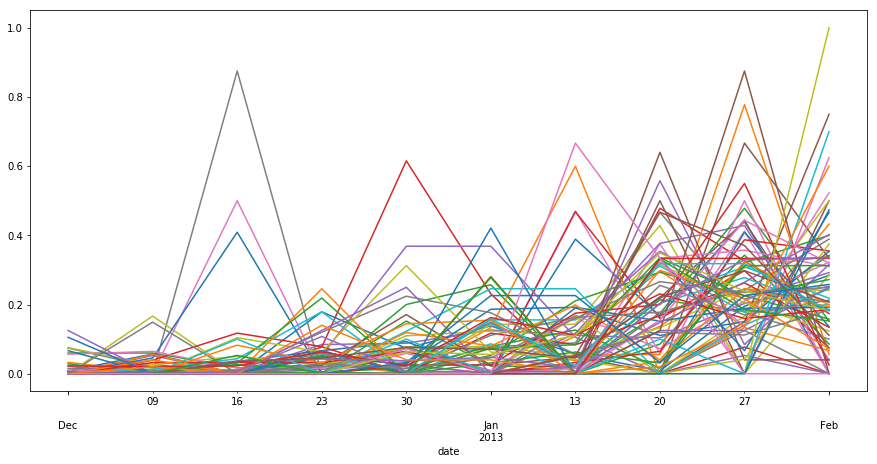

In [123]:
plt.figure(figsize=(15,7))
for clinic in cases_2013:
    cases_2013[clinic].cases.plot()
plt.show()